In [4]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 결측치 시각화를 위한 라이브러리
import missingno

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [6]:
train = pd.read_csv('5.all_train_잔액정보.csv')

In [7]:
train = train.iloc[:,1:]

In [8]:
train.columns

Index(['기준년월', 'ID', '잔액_일시불_B0M', '잔액_할부_B0M', '잔액_현금서비스_B0M',
       '잔액_리볼빙일시불이월_B0M', '잔액_리볼빙CA이월_B0M', '잔액_카드론_B0M', '월중평잔_일시불_B0M',
       '월중평잔_할부_B0M', '월중평잔_CA_B0M', '카드론잔액_최종경과월', '연체일자_B0M', '연체잔액_B0M',
       '연체잔액_일시불_B0M', '연체잔액_할부_B0M', '연체잔액_현금서비스_B0M', '연체잔액_카드론_B0M',
       '연체잔액_대환론_B0M', '잔액_현금서비스_B1M', '잔액_현금서비스_B2M', '잔액_카드론_B1M',
       '잔액_카드론_B2M', '잔액_카드론_B3M', '잔액_카드론_B4M', '잔액_카드론_B5M', '잔액_할부_B1M',
       '잔액_할부_B2M', '잔액_일시불_B1M', '잔액_일시불_B2M', '연체일수_B1M', '연체일수_B2M',
       '연체원금_B1M', '연체원금_B2M', '연체일수_최근', '연체원금_최근', '최종연체회차', '매각잔액_B1M',
       '최종연체개월수_R15M', 'RV_평균잔액_R12M', 'RV_최대잔액_R12M', 'RV_평균잔액_R6M',
       'RV_최대잔액_R6M', 'RV_평균잔액_R3M', 'RV_최대잔액_R3M', 'RV잔액이월횟수_R6M',
       'RV잔액이월횟수_R3M', '잔액_할부_유이자_B0M', '잔액_할부_무이자_B0M', '잔액_할부_해외_B0M',
       '연체잔액_일시불_해외_B0M', '연체잔액_RV일시불_B0M', '연체잔액_RV일시불_해외_B0M',
       '연체잔액_할부_해외_B0M', '연체잔액_CA_B0M', '연체잔액_CA_해외_B0M', '월중평잔', '월중평잔_일시불',
       '월중평잔_RV일시불', '월중평잔_할부', '월중평잔_CA', '월중평잔_카드론', '평잔_3M', '평잔_

In [9]:
# 이미 DataFrame 이름이 train이라면
df = train.copy()

# 6자리 문자열/정수 → datetime64[ns] (해당 월의 1일로 고정)
df['기준년월_dt'] = pd.to_datetime(df['기준년월'].astype(str), format='%Y%m')


### 내 데이터에 Segment 데이터 합치기

In [14]:
train201807= pd.read_parquet('open/train/1.회원정보/201807_train_회원정보.parquet')
train201808= pd.read_parquet('open/train/1.회원정보/201808_train_회원정보.parquet')
train201809= pd.read_parquet('open/train/1.회원정보/201809_train_회원정보.parquet')
train201810= pd.read_parquet('open/train/1.회원정보/201810_train_회원정보.parquet')
train201811= pd.read_parquet('open/train/1.회원정보/201811_train_회원정보.parquet')
train201812= pd.read_parquet('open/train/1.회원정보/201812_train_회원정보.parquet')

In [16]:
train1 = pd.concat([train201807, train201808, train201809, train201810, train201811, train201812])

In [18]:
df['Segment'] = train1['Segment'].values

### 결측치 확인
- 연체일자_B0M 은 거의 다 결측치라 봐도 무방할 정도기 때문에 해당 변수는 고려하지 않고 분석한다.

In [22]:
na_pct = df.isna().mean().mul(100).round(2)  # 소수점 2자리까지

na_pct = na_pct[na_pct.gt(0)].sort_values(ascending=False)  # 결측 있는 컬럼만
print("🔍  컬럼별 결측치 비율(%)\n")
print(na_pct.to_string())

🔍  컬럼별 결측치 비율(%)

연체일자_B0M    99.76


### 잔액_일시불_B0M
- A가 가장 크고 등급 순서대로 일시불 잔액이 작다
- 두 단계 구조: (A,B) ↔ (C,D,E)
- 절벽 지점: B→C 구간에서 가장 큰 단차가 발생.
- 긴 꼬리: D→E는 절댓값은 작지만 비율로는 큰 폭 감소.

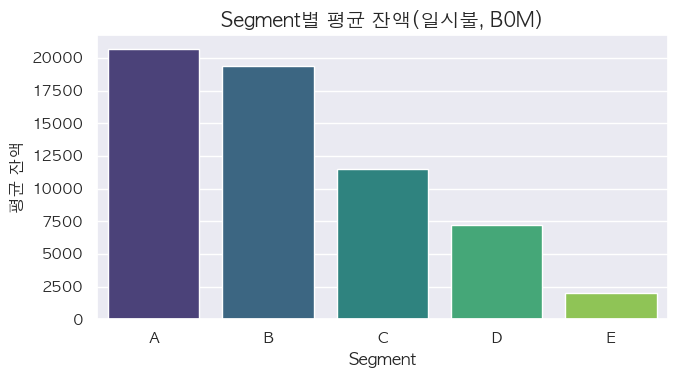

In [13]:
# 1) Segment별 평균 집계
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_일시불_B0M']
      .mean()
      .rename(columns={'잔액_일시불_B0M': '평균_잔액_일시불_B0M'})
      .sort_values('평균_잔액_일시불_B0M', ascending=False)  # 큰 값부터 보려면
)

# 2) 그래프 그리기
plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean,
    x='Segment',
    y='평균_잔액_일시불_B0M',
    palette='viridis'
)
plt.title('Segment별 평균 잔액(일시불, B0M)', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('평균 잔액')
plt.tight_layout()
plt.show()


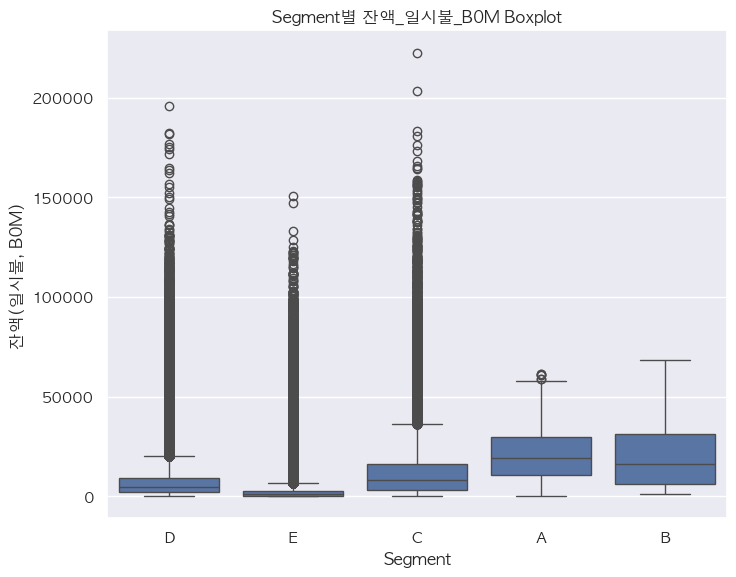

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

feature = '잔액_일시불_B0M'

plt.figure(figsize=(14, 6))

# 1) Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Segment', y=feature)
plt.title(f'Segment별 {feature} Boxplot')
plt.xlabel('Segment')
plt.ylabel('잔액(일시불, B0M)')
plt.show()


### 잔액_할부_B0M
- 상위 두 그룹(B·A) 대다수 할부 사용량 차지
- 하위 세 그룹(C·D·E)은 평균값이 1/4 이하로 떨어짐
- A: 일시불 잔액이 높았던 세그먼트이나 할부는 B보다 낮음 → 지불 패턴 차이가 있지 않을까? (예상)

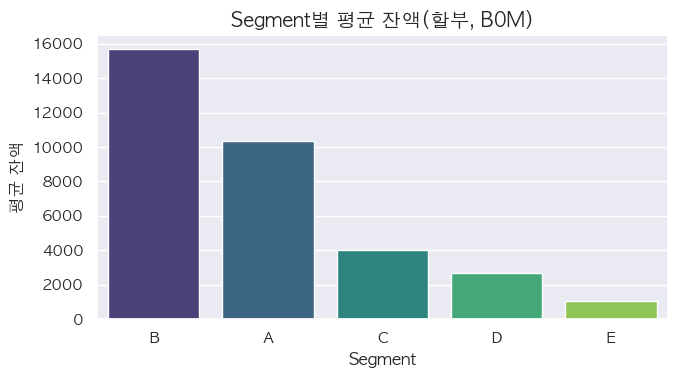

In [15]:
# 1) Segment별 평균
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_할부_B0M']
      .mean()
      .rename(columns={'잔액_할부_B0M': '평균_잔액_할부_B0M'})
      .sort_values('평균_잔액_할부_B0M', ascending=False)
)

# 2) 시각화
plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean,
    x='Segment',
    y='평균_잔액_할부_B0M',
    palette='viridis'
)
plt.title('Segment별 평균 잔액(할부, B0M)', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('평균 잔액')
plt.tight_layout()
plt.show()


### 잔액_현금서비스_B0M
- 잔액_할부와 마찬가지로 A가 B보다 크고
- 나머지는 등급 순대로 작아진다

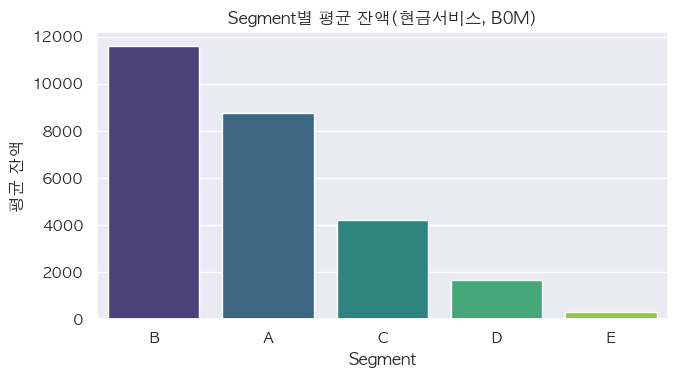

In [17]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_현금서비스_B0M']
      .mean()
      .rename(columns={'잔액_현금서비스_B0M': '평균_잔액_현금서비스_B0M'})
      .sort_values('평균_잔액_현금서비스_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_현금서비스_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(현금서비스, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액')
plt.tight_layout();  plt.show()


### 잔액_리볼빙일시불이월_B0M
- 일시불로 사용한 금액 중에서, 전액 결제하지 않고 리볼빙을 통해 남겨둔 (이월한) 금액의 잔액
즉, 원래 한 번에 갚았어야 할 카드값 중 아직 못 갚은 금액
- B-D-C-A-E 순이고
- 평균 잔액에 큰 차이는 안나지만 A가 하위권에 속하고 갑자기 D가 상위권에 위치하는 것이 흥미로움
- 솔직히 별로 차이 안나는거 같음

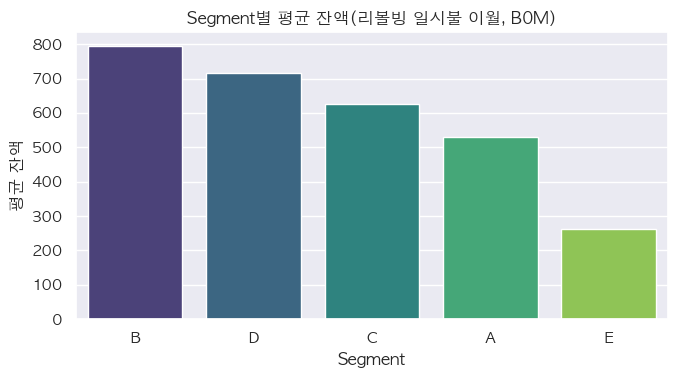

In [19]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_리볼빙일시불이월_B0M']
      .mean()
      .rename(columns={'잔액_리볼빙일시불이월_B0M': '평균_잔액_리볼빙일시불이월_B0M'})
      .sort_values('평균_잔액_리볼빙일시불이월_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_리볼빙일시불이월_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(리볼빙 일시불 이월, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액')
plt.tight_layout();  plt.show()


### 잔액_리볼빙CA이월_B0M
- 고객이 현금서비스를 이용한 뒤 전액을 결제하지 않고 리볼빙으로 돌린 금액 중, 아직 갚지 않고 남아 있는 금액
- A만 극도로 높고 다른 등급은 현저히 낮음
- A등급 이용자의 현금 서비스 이용률이 높나 ? -> 확인 필요 📌
- 심지어 B는 0에 수렴하는 것을 보니 대부분 리볼빙 일시불 이월을 하는듯 하다

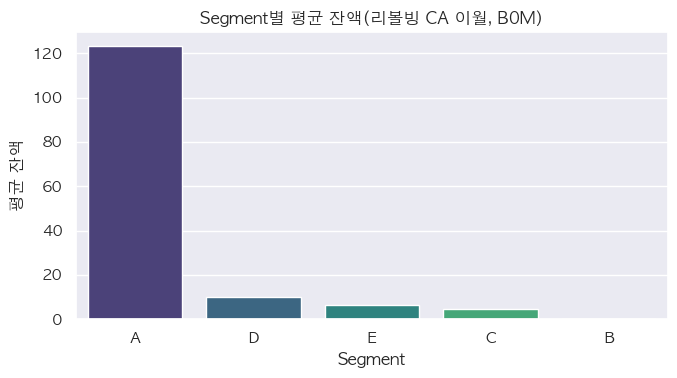

In [21]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_리볼빙CA이월_B0M']
      .mean()
      .rename(columns={'잔액_리볼빙CA이월_B0M': '평균_잔액_리볼빙CA이월_B0M'})
      .sort_values('평균_잔액_리볼빙CA이월_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_리볼빙CA이월_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(리볼빙 CA 이월, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액')
plt.tight_layout();  plt.show()


In [22]:
# Segment별 리볼빙 CA 이월 B0M 개수
df.groupby('Segment')['잔액_리볼빙CA이월_B0M'].count()

Segment
A        972
B        144
C     127590
D     349242
E    1922052
Name: 잔액_리볼빙CA이월_B0M, dtype: int64

### 잔액_카드론_B0M
- ‘B’ 세그먼트의 과도 집중
- boxplot으로 확인 필요

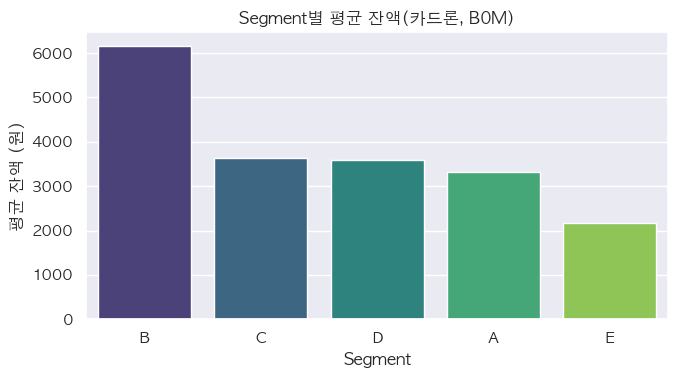

In [42]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_카드론_B0M']
      .mean()
      .rename(columns={'잔액_카드론_B0M': '평균_잔액_카드론_B0M'})
      .sort_values('평균_잔액_카드론_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_카드론_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(카드론, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액 (원)')
plt.tight_layout();  plt.show()


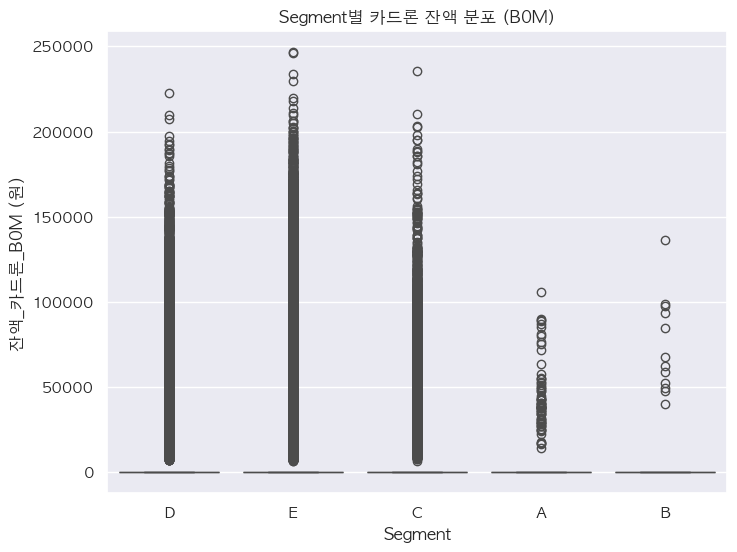

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Segment', y='잔액_카드론_B0M')
plt.title('Segment별 카드론 잔액 분포 (B0M)')
plt.xlabel('Segment')
plt.ylabel('잔액_카드론_B0M (원)')
plt.show()


### 월중평잔_일시불_B0M / 월중평잔_할부_B0M / 월중평잔_CA_B0M

- A는 “일시불” 집중형: 일시불/전체 ≈51 %
- B는 “신용(할부+CA)” 집중형: 할부+CA/전체 ≈59 %
- → B 세그먼트가 가장 공격적으로 할부·현금서비스를 활용

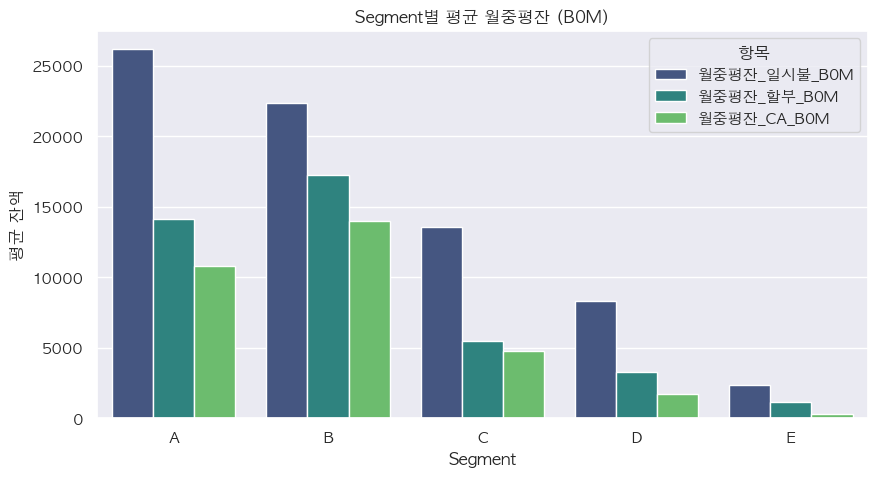

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 비교할 칼럼 목록
cols = [
    '월중평잔_일시불_B0M',
    '월중평잔_할부_B0M',
    '월중평잔_CA_B0M'
]

# 2) Segment별 평균 구하기
seg_mean = (
    df.groupby('Segment')[cols]
      .mean()
      .reset_index()
)

# 3) 긴 형태로 변환 → 항목별로 hue 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 시각화
plt.figure(figsize=(9, 5))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('Segment별 평균 월중평잔 (B0M)')
plt.xlabel('Segment')
plt.ylabel('평균 잔액')
plt.legend(title='항목')      # 범례 제목
plt.tight_layout()
plt.show()


### 연체 잔액에 관련된 칼럼들

- A·B 그룹은 평군 연체잔액(전체·세부 모두)이 0에 가깝습니다.
- 연체는 C·D·E 세그먼트에서 많이 발생

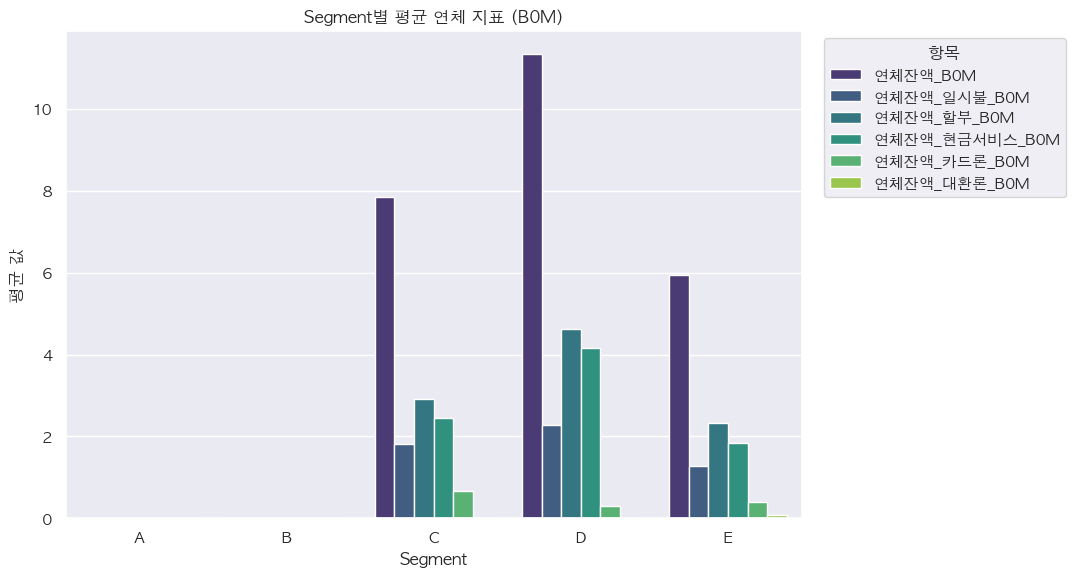

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 비교할 연체 지표 목록
overdue_cols = [
    '연체잔액_B0M',
    '연체잔액_일시불_B0M',
    '연체잔액_할부_B0M',
    '연체잔액_현금서비스_B0M',
    '연체잔액_카드론_B0M',
    '연체잔액_대환론_B0M'
]

# 2) Segment별 평균 계산
seg_mean_overdue = (
    df.groupby('Segment')[overdue_cols]
      .mean()
      .reset_index()
)

# 3) 긴(long) 형태로 변환 – 그래프에서 hue로 쓰기 위함
seg_long_overdue = seg_mean_overdue.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균값'
)

# 4) 시각화
plt.figure(figsize=(11, 6))
sns.barplot(
    data=seg_long_overdue,
    x='Segment',
    y='평균값',
    hue='항목',
    palette='viridis'
)
plt.title('Segment별 평균 연체 지표 (B0M)')
plt.xlabel('Segment')
plt.ylabel('평균 값')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')  # 범례를 밖으로
plt.tight_layout()
plt.show()


### 연체 원금 관련 칼럼들
- 역시 C, D, E 밖에 없음

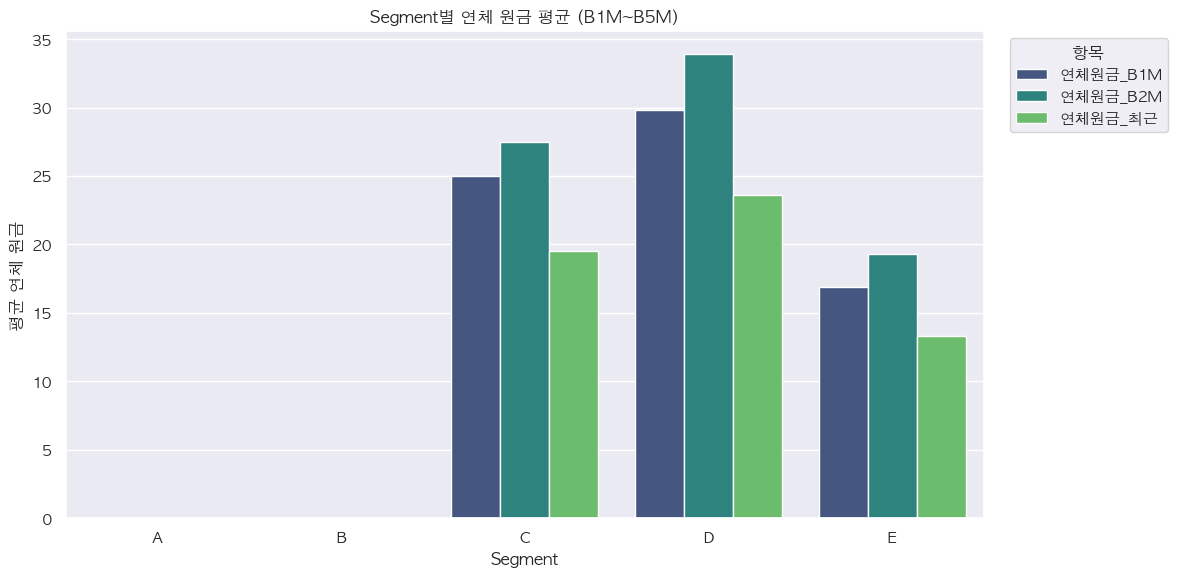

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    '연체원금_B1M', '연체원금_B2M', '연체원금_최근'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)

# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('Segment별 연체 원금 평균 (B1M~B5M)')
plt.xlabel('Segment')
plt.ylabel('평균 연체 원금')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 잔액 관련 칼럼들
- 프리미엄(A·B): ‘즉시 결제 후 상환’이 뚜렷
- 중·하위(C·D·E): 카드론 이월 누적, 상환 속도 느림

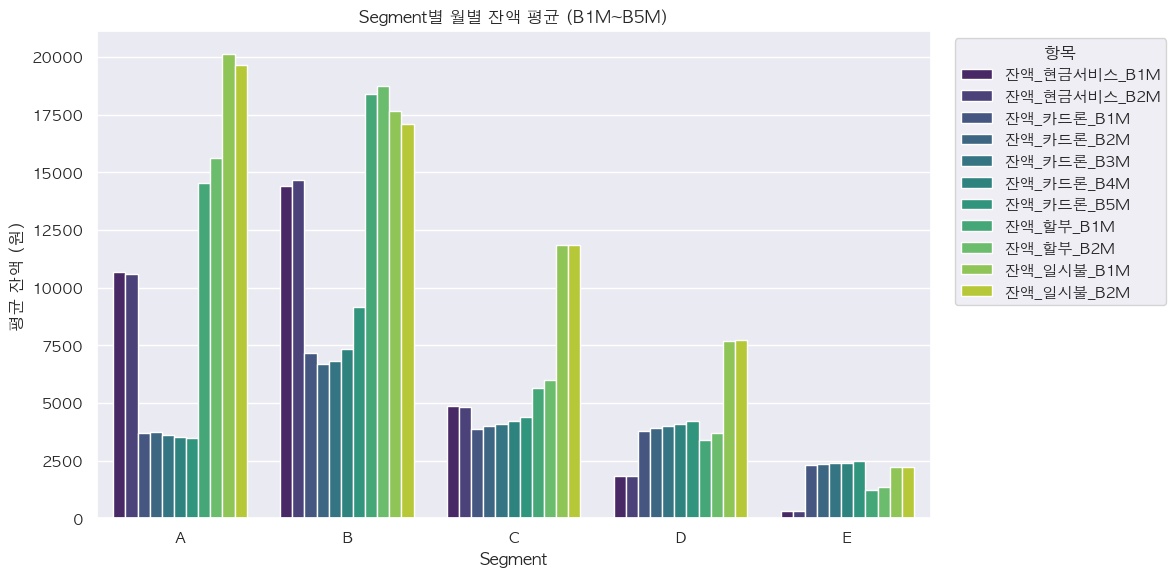

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    '잔액_현금서비스_B1M', '잔액_현금서비스_B2M',
    '잔액_카드론_B1M', '잔액_카드론_B2M', '잔액_카드론_B3M',
    '잔액_카드론_B4M', '잔액_카드론_B5M',
    '잔액_할부_B1M', '잔액_할부_B2M',
    '잔액_일시불_B1M', '잔액_일시불_B2M'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)

# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('Segment별 월별 잔액 평균 (B1M~B5M)')
plt.xlabel('Segment')
plt.ylabel('평균 잔액 (원)')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 최근 3개월 동안의 리볼빙 정보
- D C B A E 순서

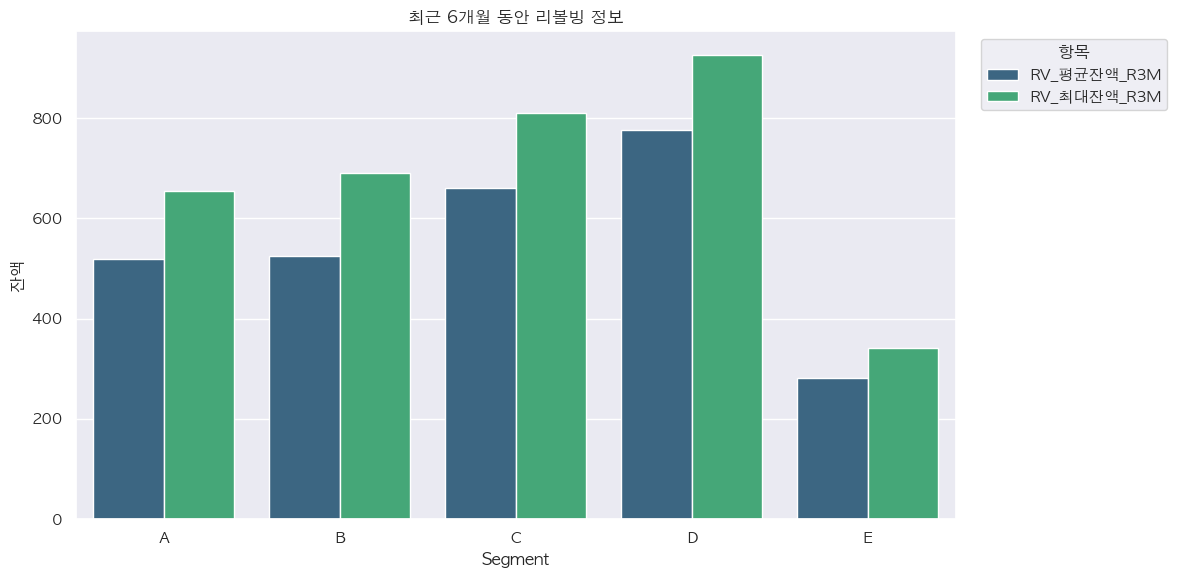

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    'RV_평균잔액_R3M', 'RV_최대잔액_R3M'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)

# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('최근 6개월 동안 리볼빙 정보')
plt.xlabel('Segment')
plt.ylabel('잔액')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 최근 6개월 동안의 리볼빙 정보
- 3개월 정보랑 비슷하다

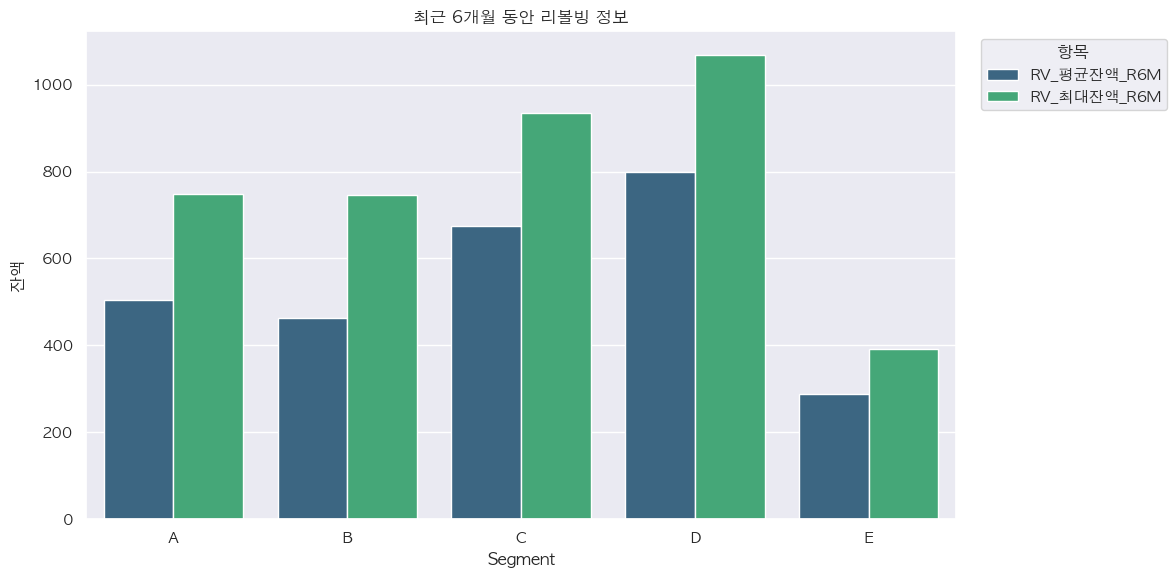

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    'RV_평균잔액_R6M', 'RV_최대잔액_R6M'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)

# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('최근 6개월 동안 리볼빙 정보')
plt.xlabel('Segment')
plt.ylabel('잔액')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 잔액 할부 관련 컬럼

- 무이자 할부(초록막대) 가 세그먼트 전반에 걸쳐 가장 큰 비중을 차지
- 해외 할부(중간녹색막대) 가 그다음, 유이자 할부(진한남색막대) 는 전체 잔액 대비 아주 소량

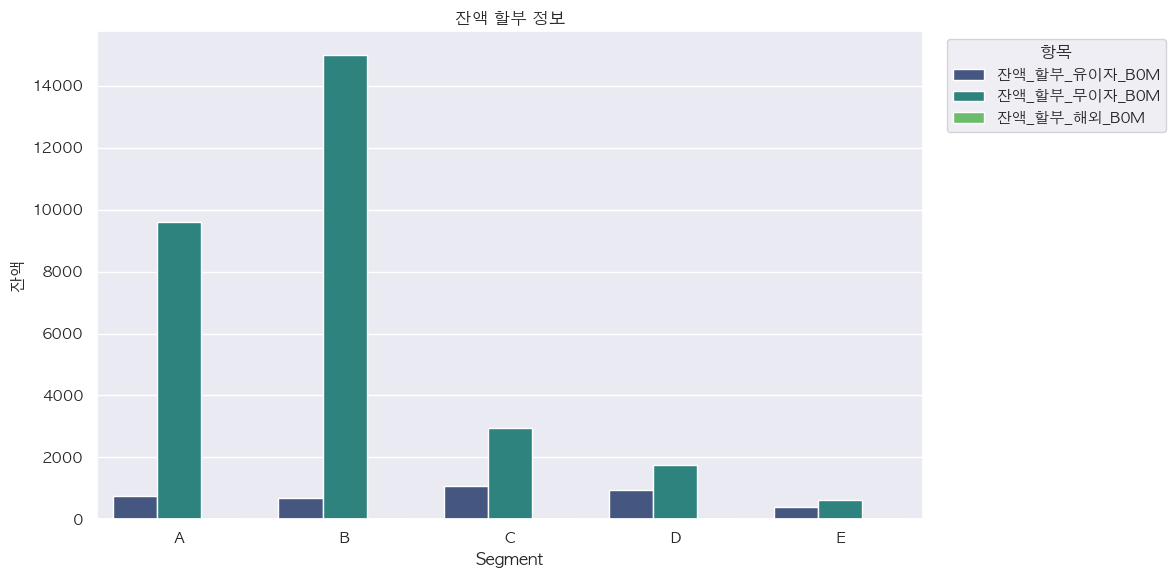

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    '잔액_할부_유이자_B0M', '잔액_할부_무이자_B0M', '잔액_할부_해외_B0M'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)

# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('잔액 할부 정보')
plt.xlabel('Segment')
plt.ylabel('잔액')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 월평균 잔액 정보
- 리볼빙 일시불(청록색) : 전반적으로 1–3 천원대로 미미
- 
- A: 즉시 일시불 + 일부 할부
- B: 강한 할부·카드론·현금서비스 + (약한) 일시불
- C·D·E: 분할+이월 쪽으로 무게중심 이동, 카드론 의존↑

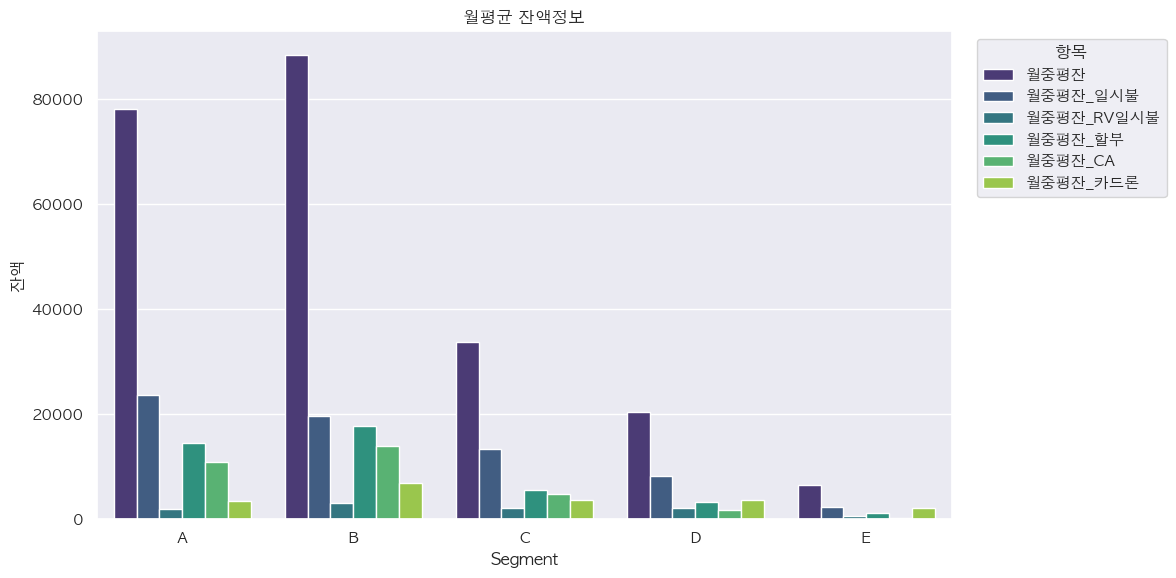

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    '월중평잔', '월중평잔_일시불',
       '월중평잔_RV일시불', '월중평잔_할부', '월중평잔_CA', '월중평잔_카드론'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)
 
# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('월평균 잔액정보')
plt.xlabel('Segment')
plt.ylabel('잔액')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 최근 3개월 동안의 평균 잔액 정보
- 당월 평균이랑 비슷하다.
- 카드론 비중이 누적평균에서 조금 높아진 점 보임

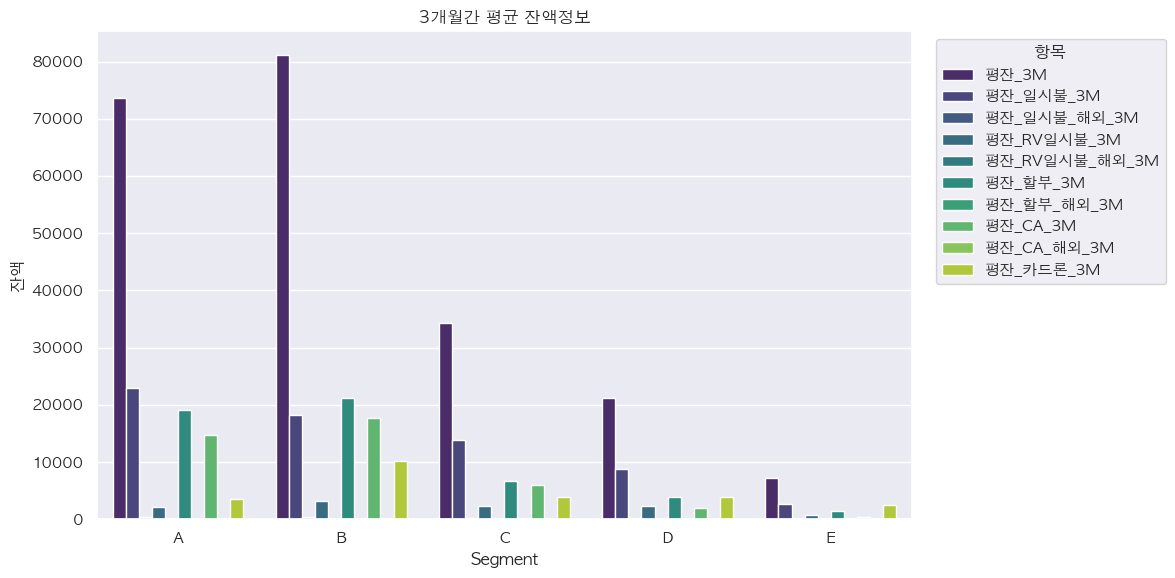

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    '평잔_3M', '평잔_일시불_3M',
       '평잔_일시불_해외_3M', '평잔_RV일시불_3M', '평잔_RV일시불_해외_3M', '평잔_할부_3M',
       '평잔_할부_해외_3M', '평잔_CA_3M', '평잔_CA_해외_3M', '평잔_카드론_3M'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)

# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('3개월간 평균 잔액정보')
plt.xlabel('Segment')
plt.ylabel('잔액')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 최근 6개월 동안의 평균 잔액 정보
- 3개월 정보랑 비슷함

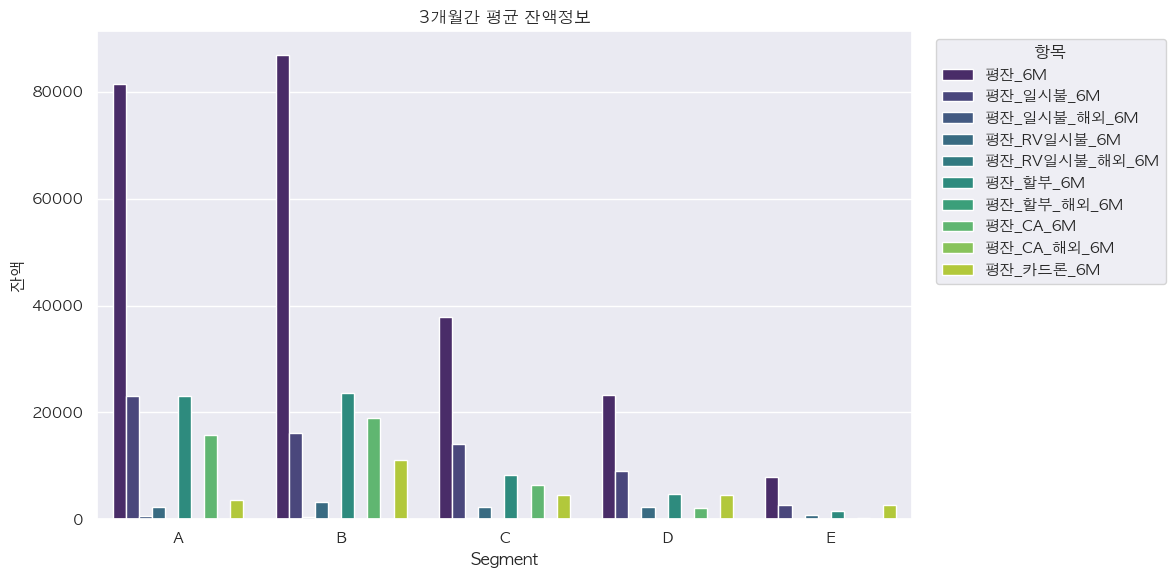

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 대상 컬럼
balance_cols = [
    '평잔_6M',
       '평잔_일시불_6M', '평잔_일시불_해외_6M', '평잔_RV일시불_6M', '평잔_RV일시불_해외_6M',
       '평잔_할부_6M', '평잔_할부_해외_6M', '평잔_CA_6M', '평잔_CA_해외_6M', '평잔_카드론_6M'
]

# 2) Segment별 평균 계산
seg_mean = (
    df.groupby('Segment')[balance_cols]
      .mean()
      .reset_index()
)

# 3) long 형태로 변환 → hue로 사용
seg_long = seg_mean.melt(
    id_vars='Segment',
    var_name='항목',
    value_name='평균_잔액'
)

# 4) 바플롯
plt.figure(figsize=(12, 6))
sns.barplot(
    data=seg_long,
    x='Segment',
    y='평균_잔액',
    hue='항목',
    palette='viridis'
)
plt.title('6개월간 평균 잔액정보')
plt.xlabel('Segment')
plt.ylabel('잔액')
plt.legend(title='항목', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



### 피처 선택을 할 경우...

| 카테고리           | 추천 컬럼                                                                                                        | 선택 근거                                                              |
| -------------- | ------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------ |
| **현재(당월) 잔액**  | `잔액_일시불_B0M`<br>`잔액_할부_B0M`<br>`잔액_현금서비스_B0M`<br>`잔액_카드론_B0M`<br>`잔액_리볼빙일시불이월_B0M`<br>`잔액_리볼빙CA이월_B0M` | • Segment 간 평균 차이가 가장 뚜렷<br>• 이월 잔액 두 종(일시불/CA)도 “A vs 나머지” 분리력 우수 |
| **월중평잔 (B0M)** | `월중평잔_일시불_B0M`<br>`월중평잔_할부_B0M`<br>`월중평잔_CA_B0M`                                                             | • 월중평잔은 당월 피크 편향 완화<br>• 정상적 소비 규모를 더 안정적으로 반영                     |
| **연체 상태**      | `연체잔액_B0M`<br>`연체원금_최근`<br>`연체일수_최근`                                                                         | • A·B는 0, C·D·E만 보유 → 강력한 구분자<br>• 원금·일수 정보로 리스크 심각도까지 캡처          |
| **리볼빙 지표**     | `RV_평균잔액_R3M`<br>`RV_최대잔액_R3M`<br>`RV잔액이월횟수_R3M`                                                             | • 평균·최대값만으로는 빈도 정보가 빠짐 → 이월 횟수 추가<br>• 3개월 단위가 세그먼트 구분력 최적         |
| **카드론 경과정보**   | `카드론잔액_최종경과월`<br>`최종연체개월수_R15M`                                                                              | • 경과월·연체개월수 자체가 등급별·리스크별 차이 매우 큼                                   |
| **단기·중기 평잔**   | `평잔_3M`<br>`평잔_일시불_3M`<br>`평잔_할부_3M`<br>`평잔_CA_3M`<br>`평잔_카드론_3M`                                            | • 6개월 평균은 3개월 평균과 거의 동일 패턴 → 차원 축소 차원에서 3M만 사용해도 충분                |


In [27]:
df.query('ID == "TRAIN_00000"')['Segment']

0          D
400000     D
800000     D
1200000    D
1600000    D
2000000    D
Name: Segment, dtype: object